## Calculating the distance to the Palomar 13 globular cluster (v1.0)

Author: Luke Bischoff<br>
Created: 18 DECEMBER 2020 12:46<br>
Updated: 18 DECEMBER 2020 12:47

##### Introduction
This document aims to measure the distance to the Palomar 13 (PAL13) globular cluster in the Milky Way Galaxy. This is achieved by using RR Lyrae variable stars within the cluster and analysing their apparent magnitudes and periods in the form of a PL relation. A plot of the RR Lyrae's individual average apparent magnitude against their period enables a PL relation to be fit to the data and compared to a calibrated PL relation, which is based in absolute magnitudes. The distance can then be calculated from the distance modulus.
##### Contents
1. List of python imports and modules<br>
2. User defined functions<br>
3. Initialisation and options<br>
3a. Initialisation: choosing globular cluster and channel information<br>
3b. Options: choosing photometry parameters<br>
4. Master source list: creating a list of all detected stars in the main frames<br>
5. Photometry: performing photometry on epoch data and matching to master source list (optimised for PSF only)<br>
6. Raw light curves: constructs raw light curves for identified RR Lyraes<br>
7. GLOESS analysis: constructs light curves with a smoothing function and returns average magnitudes and uncertainties<br>
8. PL relations: fits PL relations for the data in each channel and returns distances<br>

##### Import list

In [1]:
import math
import glob
import copy
import numpy as np
import pandas as pd
import astroalign as aa
import matplotlib
import matplotlib.pyplot as plt
from gloess_plot import GLOESSpy
from scipy.optimize import curve_fit
from astropy import wcs
from astropy import units as u
from astropy.io import fits # used for FITS file management
from astropy.io import ascii
from astropy.time import Time
from astropy.stats import sigma_clipped_stats # used within star detection
from astropy.table import Table, join
from astropy.nddata import NDData
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.coordinates import Angle
from astropy.visualization import simple_norm
from astropy.io.votable import parse_single_table
from astropy.modeling.fitting import LevMarLSQFitter
from photutils import aperture_photometry # used to perform photometry using annuli
from photutils import DAOStarFinder # used for the star finding algorithm
from photutils import CircularAperture, CircularAnnulus
from photutils import EPSFBuilder
from photutils.psf import extract_stars
from photutils.psf import DAOGroup
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground
from astroquery.irsa_dust import IrsaDust
from matplotlib import rc
from matplotlib.colors import LogNorm

plt.rcParams.update({'font.size': 18})
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

##### User defined functions

In [2]:
## COORDINATE CONVERSION ##
def Coord_Conv(header, x_list, y_list):
    # CONVERTS COORDINATES IN X, Y TO RIGHT ASCENSION AND DECLINATION USING ICRS COORDINATES
    # header: INPUT HEADER REFERENCE TO OBTAIN WCS
    # x_list, y_list: LIST OF X AND Y COORDINATES TO BE CONVERTED
    w = wcs.WCS(header)
    coord = np.transpose((x_list, y_list))
    world = w.wcs_pix2world(coord, 0)
    ra, dec = world[:, 0], world[:, 1]
    c = SkyCoord(ra, dec, frame = 'icrs', unit = 'deg')
    return ra, dec, c

##### Initialisation and options

In [18]:
## INPUT DATA PATHS ##

cluster_input = 'PAL13'

if cluster_input == 'PAL5':
    epoch_path = 'PAL5_data/*/'
    master_path = 'PAL5_data/PAL5/'
    general_path = 'PAL5_data/'
elif cluster_input == 'PAL13':
    epoch_path = 'PAL13_data/*/'
    master_path = 'PAL13_data/PAL13/'
    general_path = 'PAL13_data/'
elif cluster_input == 'IC4499':
    epoch_path = 'IC4499_data/*/'
    master_path = 'IC4499_data/IC4499/'
    general_path = 'IC4499_data/'
else:
    raise ValueError('Cluster not found: input clusters `PAL5`, `PAL13` or `IC4499` only!')

## CHANNEL ##

channel = '4p5um'

if channel == '3p6um':
    aper_corr = 1.1233            # aperture correction for 337 (6,6,14) apertures in channel 1, c.f IRAC handbook §4.10
    ap_err    = aper_corr * 0.02  # uncertainty to ~2% as per IRAC handbook
    zmag      = 18.80             # zeropoint magnitude given in IRAC handbook §4.8
    zmag_err  = 0.02              # uncertainty calculated from F0 = 280.9 +/- 4.1 in IRAC handbook
elif channel == '4p5um':
    aper_corr = 1.1336
    ap_err    = aper_corr * 0.02
    zmag      = 18.32
    zmag_err  = 0.02
else:
    raise ValueError('Incorrect channel input: only values 3p6um or 4p5um permitted.')
    
## PHOTOMETRY PARAMETERS AND OPTIONS ##

fwhm = 5.               # APPROX. FULL-WIDTH AT HALF-MAXIMUM FOR SAMPLE OF STARS
sigma = 4.              # SIGMA VALUE FOR MASTER STAR LIST AND PHOTOMETRY STAR DETECTION AND SIGMA-CLIPPING
sigma_epsf = 50.        # SIGMA VALUE FOR ePSF MODEL STAR DETECTION
r_ap = 6.               # APERTURE RADIUS AROUND DETECTED SOURCE
r_in = 6.               # INNER RADIUS FOR STAR ANNULI
r_out = 14.             # OUTER RADIUS FOR STAR ANNULI
roundlo = -0.5          # ROUND VALUE FOR STAR DETECTION ALGORITHM
roundhi = +0.5
sharphi = 1.0           # SHARP VALUE FOR PHOTOMETRY STAR DETECTION
sharphi_model = 0.8     # SHARP VALUE FOR ePSF MODEL STAR DETECTION

phot_method = 'psf'     # SELECT PHOTOMETRY METHOD: 'aperture' or 'psf'

##### Master source list

FITS file information:
FILE = PAL13_data/PAL13/PAL13_4p5um.fits



Number of ePSF sources found = 60

Number of refined ePSF sources = 40



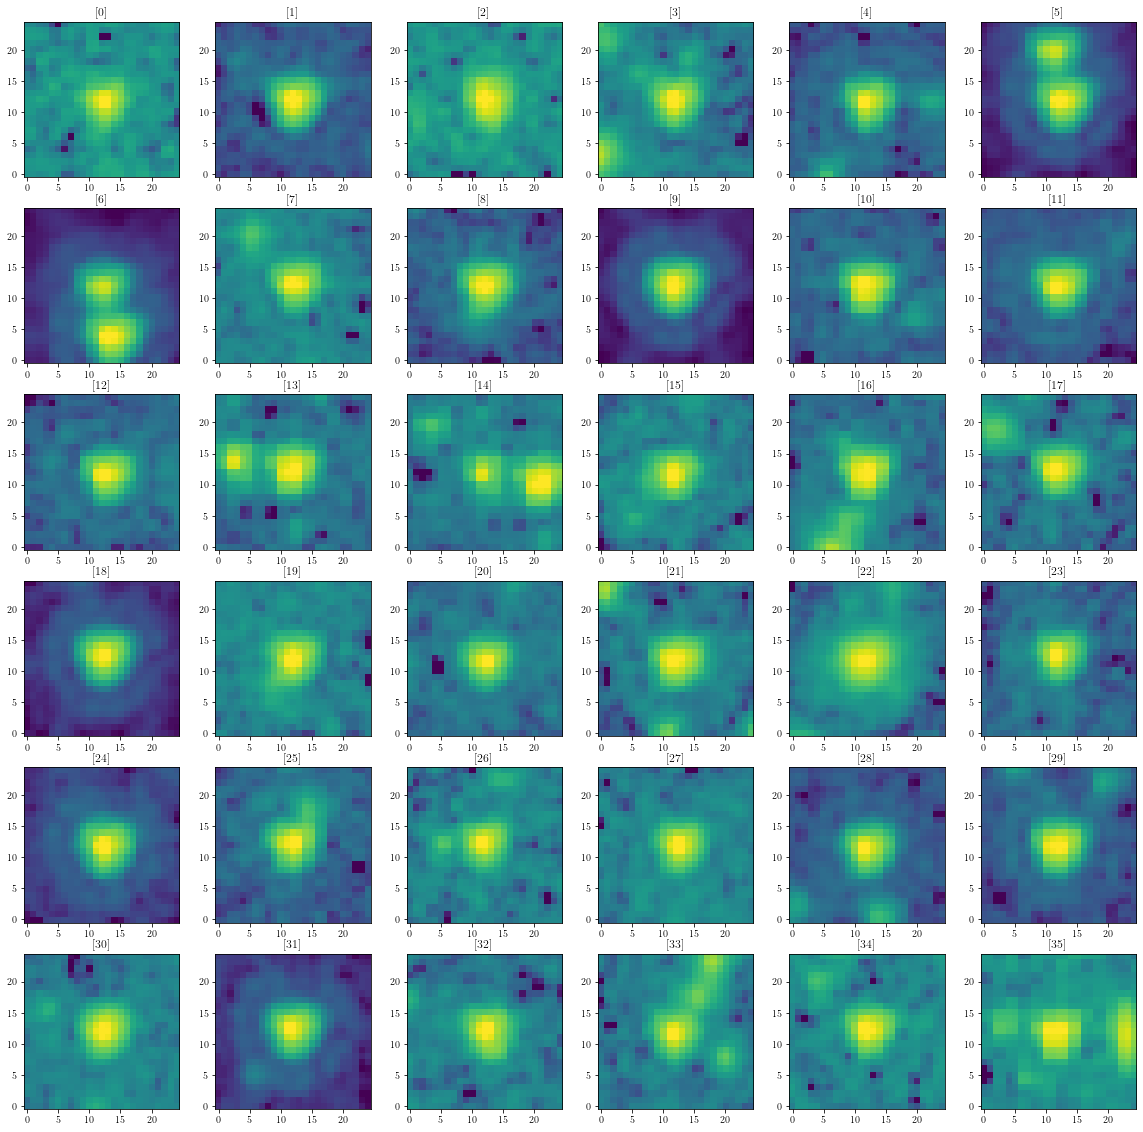

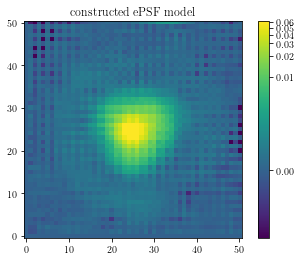

Remove any poor quality model stars from the model by their ID. Use ID -99 to escape
5 6 13 14 35


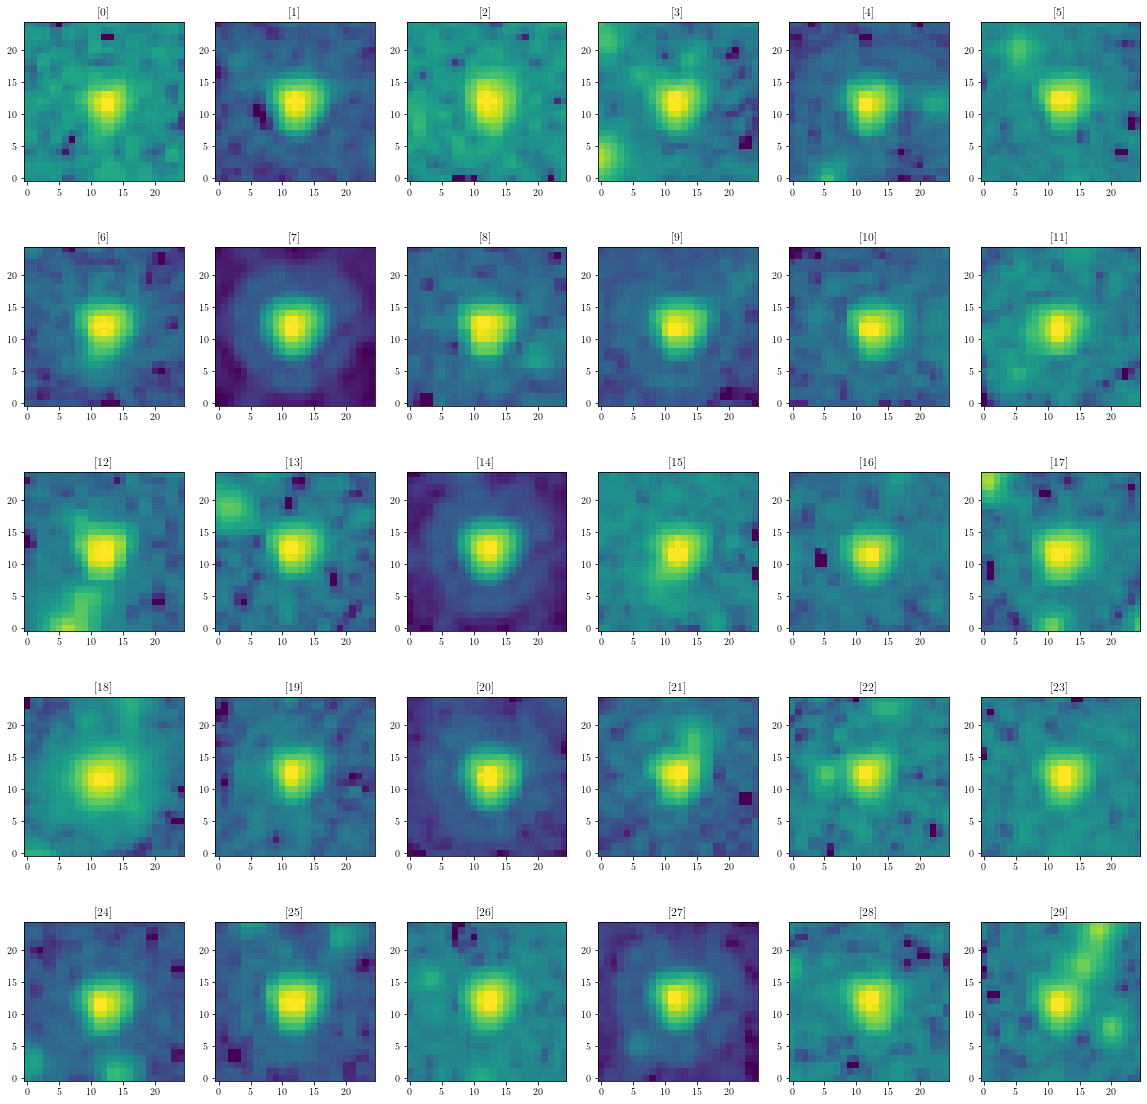

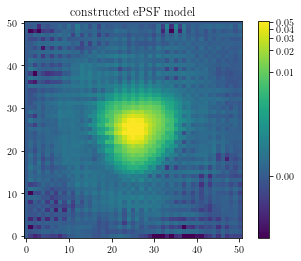

Remove any poor quality model stars from the model by their ID. Use ID -99 to escape
-99
Escape completed



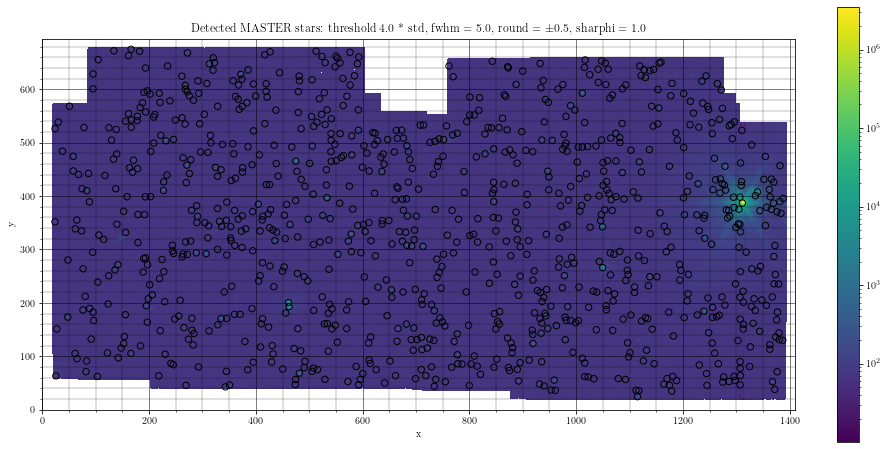

Number of MASTER stars detected = 961



Number of MASTER stars found from PSF = 1667



idx,master_id,x_0,y_0,ra,dec
0,0,1114.9145138693282,24.303639350696578,346.7825753707754,12.67635861149093
1,1,1117.4477234399744,35.45970292382526,346.7809779669889,12.675260103983197
2,2,1112.0942259242474,36.241062833693675,346.7805062474785,12.676035534614623
3,3,953.1900727563333,36.62838263947686,346.77010578968844,12.700499447373547
4,4,960.8737710895157,36.142669094256135,346.7706825132271,12.699346165185437
5,5,940.0725448449197,44.48467726387292,346.7680111092297,12.702022227151446
6,6,931.2802122486798,47.85920926436453,346.7669058665165,12.703162963454496
7,7,958.8702728294546,55.26293556635565,346.76753168748434,12.698441146018242
8,8,342.97887604495037,42.65684942003023,346.72943051389956,12.794151745666174
9,9,350.8583127677687,45.96883280790366,346.72942026999266,12.792727220140339


In [23]:
## BUILDING MASTER SOURCE LIST USING MOSAICKED IMAGE ##

master_file = master_path+cluster_input+'_'+channel+'.fits'

## OPENING FITS FILE AND EXTRACTING DATA ##

with fits.open(master_file) as hdr_list:
    m_hdr = hdr_list[0].header
    if channel == '4p5um':
        counts = m_hdr['EXPTIME'] / 0.1469
    else:
        counts = m_hdr['EXPTIME'] / m_hdr['FLUXCONV']
    im_data = fits.getdata(master_file, ext = 0)
    m_data = im_data * counts
    print('FITS file information:\nFILE = {0}\n'.format(master_file))

## BUILDING ePSF FOR MASTER FILE ##

mean_epsf, median_epsf, std_epsf = sigma_clipped_stats(m_data, sigma = sigma) # sigma-clipping on data

starfind_init = DAOStarFinder(fwhm = fwhm, threshold = sigma_epsf * std_epsf, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi_model)
epsf_sources = starfind_init(m_data)
print('Number of ePSF sources found = {0}\n'.format(len(epsf_sources)))

## MASK BRIGHT ZONE IN CHANNEL 2 FOR EPSF ##

if channel == '4p5um':
    x_mask = epsf_sources['xcentroid']
    y_mask = epsf_sources['ycentroid']
    del epsf_sources
    xlim = 1150
    epsf_mask = (x_mask < xlim)
    epsf_sources = Table()
    epsf_sources['xcentroid'] = x_mask[epsf_mask]
    epsf_sources['ycentroid'] = y_mask[epsf_mask]

## STAR CUTOUTS FOR ePSF ##

cutout_size = 200
hsize = (cutout_size - 1) / 2
x = epsf_sources['xcentroid']
y = epsf_sources['ycentroid']
mask = ((x > hsize) & (x < (m_data.shape[1] - 1 - hsize)) &
        (y > hsize) & (y < (m_data.shape[0] - 1 - hsize)))

star_tbl = Table()       # build table of star sources
star_tbl['x'] = x[mask]
star_tbl['y'] = y[mask]
star_tbl['id'] = range(len(star_tbl))
print('Number of refined ePSF sources = {0}\n'.format(len(star_tbl)))

## EXTRACT STARS ##

epsf_data = m_data - median_epsf
while True:
    nddata = NDData(data = epsf_data)
    epsf_stars = extract_stars(nddata, star_tbl, size = 25)

    ## VISUALISE MODEL STARS ##
    
    ncols = 6
    nrows = int(np.floor(len(epsf_stars) / ncols))
    remaining = len(epsf_stars) - ncols * nrows

    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20), squeeze = True)
    ax = ax.ravel()
    for i in range(nrows * ncols):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i].set_title([i])
    plt.show()
    for i in range(ncols * nrows, len(epsf_stars)):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i - ncols * nrows].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i - ncols * nrows].set_title([i])
    plt.show()
    plt.close()
    
    ## BUILD ePSF ##

    epsf_builder = EPSFBuilder(oversampling = 2, maxiters = 10, progress_bar = True)
    epsf, fitter = epsf_builder(epsf_stars)
    
    norm = simple_norm(epsf.data, 'log', percent = 99.)
    plt.imshow(epsf.data, cmap = 'viridis', norm = norm, origin = 'lower')
    plt.title('constructed ePSF model')
    plt.colorbar()
    plt.show()
    
    print('Remove any poor quality model stars from the model by their ID. Use ID -99 to escape')
    remove = [int(k) for k in input().split()]
    
    if remove == [-99]:
        print('Escape completed\n')
        break
    
    star_tbl.add_index('id')
    bad_id = star_tbl.loc_indices[remove]
    star_tbl.remove_rows(bad_id)

    
## SOURCE DETECTION ##

mean_m, median_m, std_m = sigma_clipped_stats(m_data, sigma = sigma)

master_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma * std_m, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
master_sources = master_daofind(m_data)

# PLOT INITIAL DETECTED SOURCES
master_positions = np.transpose((master_sources['xcentroid'], master_sources['ycentroid']))
master_apertures = CircularAperture(master_positions, r = r_ap)

plt.imshow(m_data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
master_apertures.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Detected MASTER stars: threshold {0} * std, fwhm = {1}, round = $\pm${2}, sharphi = {3}'
          .format(sigma, fwhm, roundhi, sharphi))
plt.minorticks_on()
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .25, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()
plt.close()
print('Number of MASTER stars detected = {0}\n'.format(len(master_sources)))

## MASK BRIGHT ZONE IN CHANNEL 2 FOR MASTER SOURCES ##

if channel == '4p5um':
    id_mask = master_sources['id']
    x_mask = master_sources['xcentroid']
    y_mask = master_sources['ycentroid']
    del master_sources
    xlim = 1150
    m_mask = (x_mask < xlim)
    master_sources = Table()
    master_sources['id'] = id_mask[m_mask]
    master_sources['xcentroid'] = x_mask[m_mask]
    master_sources['ycentroid'] = y_mask[m_mask]
    
## RENAME STAR LIST HEADERS ##

master_sources['xcentroid'].name = 'x_0'
master_sources['ycentroid'].name = 'y_0'
master_sources['id'].name = 'master_id'

## PSF ROUTINE ON MASTER LIST ##

daogroup = DAOGroup(crit_separation = sigma * fwhm)

data_psf_m = np.nan_to_num(m_data, nan = 1**-7)

epsf.x_0.fixed = True
epsf.y_0.fixed = True
pos_init_m = Table(names = ['x_0', 'y_0'], data = [master_sources['x_0'], master_sources['y_0']])

PSF_photometry = IterativelySubtractedPSFPhotometry(finder = master_daofind,
                                                    group_maker = daogroup,
                                                    bkg_estimator = MMMBackground(),
                                                    psf_model = epsf,
                                                    fitter = LevMarLSQFitter(),
                                                    niters = 2,
                                                    aperture_radius = r_ap,
                                                    fitshape = (11, 11))

m_phot = PSF_photometry(image = data_psf_m, init_guesses = pos_init_m)
residual_image = PSF_photometry.get_residual_image()

print('Number of MASTER stars found from PSF = {0}\n'.format(len(m_phot)))

## COORDINATE CONVERSION ##

master_list = copy.copy(m_phot)
del master_list['flux_0', 'group_id', 'x_fit', 'y_fit', 'flux_fit', 'flux_unc', 'iter_detected']
master_list['id'].name = 'phot_id'

master_list['master_id'] = int(0)
for i in range(len(master_list)):
    master_list['master_id'][i] = i
    
del master_list['phot_id']
new_order = ['master_id', 'x_0', 'y_0']
master_list = master_list[new_order]

ra_m, dec_m, c_m = Coord_Conv(m_hdr, master_list['x_0'], master_list['y_0'])

master_list['ra'] = ra_m
master_list['dec'] = dec_m

## EXPORT AND SAVE FILE -- SHOW IN NOTEBOOK ##

master_list.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\{0}_master_list_{1}.txt'.format(cluster_input, channel), format = 'csv', overwrite = True)

master_list.show_in_notebook()

##### Photometry

In [24]:
## PHOTOMETRY ON EPOCHS ##

## INITIALISE MAIN TABLE ##

main_table = copy.copy(master_list)

## STORE EPOCH TIMES AS MODIFIED JULIAN DATE [MJD] ##

lctime = []

## EPOCH LOOP COUNTER ##

epoch = 0

## PHOTOMETRY LOOP ##

path1 = epoch_path+cluster_input+'__e[0-9]_'+channel+'.fits'
path2 = epoch_path+cluster_input+'__e[0-9][0-9]_'+channel+'.fits'

for file in glob.glob(path1, recursive = True) + glob.glob(path2, recursive = True):
    epoch += 1
    print('EPOCH NUMBER = {0}\n'.format(epoch))
    ## OPENING FITS FILE AND EXTRACTING DATA ##
    with fits.open(file) as hdr_list:
        e_hdr = hdr_list[0].header
        counts = e_hdr['EXPTIME'] / e_hdr['FLUXCONV']
        time = Time(e_hdr['DATE_OBS'])
        
        im_data = fits.getdata(file, ext = 0)
        e_data = im_data * counts
        
        print('FITS file information:\nFILE = {0}\nDATE = {1}\n\n'.format(file, time))
    
    ## EXTRACT TIME FROM EPOCH ##
    
    lctime.append(Time(e_hdr['DATE_OBS'], format = 'isot', scale = 'utc').mjd)
    
    ## EXTRACTING LOC-DEPENDENT CORRECTION ##
    corr_file = general_path+cluster_input+'__e'+str(epoch)+'/'+cluster_input+'__e'+str(epoch)+'_correction_'+channel+'.fits'
    with fits.open(corr_file) as hdu_list:
        corr_data = hdu_list[0].data
    
    mean_val, median_val, std_val = sigma_clipped_stats(e_data, sigma = sigma)

    ## PHOTOMETRY LOOP ##
    if phot_method == 'aperture':
        ## SOURCE DETECTION ON IMAGE ##
        daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma * std_val, roundlo = roundlo, roundhi = roundhi)
        sources = daofind(data) #- median_val) # necessary here?
        print('Number of stars detected: {}'.format(len(sources)))
        positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
        apertures = CircularAperture(positions, r = r_ap)

        plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
        plt.colorbar(fraction = 0.05)
        apertures.plot(color = 'black', lw = 1., alpha = .75)
        plt.title('Aperture photometry on epoch {} in channel {}: sigma = {}, fwhm = {}, roundlo = {}, roundhi = {}'
                  .format(j, channel, sigma_val, fwhm, roundlo, roundhi))
        plt.grid(b = True, which = 'major', lw = .5, alpha = .4, color = 'black')
        plt.gcf().set_size_inches(15, 8)
        plt.show()
        plt.close()
        
        ## APERTURE PHOTOMETRY ##
    
        positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
        circular_apertures = CircularAperture(positions, r = r_ap)
        annuli_apertures = CircularAnnulus(positions, r_in = r_in, r_out = r_out)
        apertures = [circular_apertures, annuli_apertures]

        # INITIAL APERTURE PHOTOMETRY TABLE
        phot_init = aperture_photometry(e_data, apertures)

        # BACKGROUND SUBTRACTION USING SIGMA-CLIPPING
        annulus_masks = annuli_apertures.to_mask(method = 'center')

        bkg_median = []
        for mask in annulus_masks:
            annulus_data = mask.multiply(e_data)
            annulus_data_1d = annulus_data[mask.e_data > 0] # extract 1D array of data values
            _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d) # utilise sigma clipping on the annulus masks
            bkg_median.append(median_sigclip)

        bkg_median = np.array(bkg_median)
        # APPEND bkg_median, aperture background AND aperture sum background VALUES TO PHOTOMETRY DATA
        phot_init['annulus_median'] = bkg_median
        phot_init['aper_bkg'] = bkg_median * circular_apertures.area
        phot_init['aper_sum_bkgsub'] = phot_init['aperture_sum_0'] - phot_init['aper_bkg']
        
        ## PHOTOMETRY: UNCERTAINTIES ##

        # THIS FOLLOWS  §2 (pp 8) OF Reach et al 2005
        mean_bkg = phot_init['aperture_sum_1'] / annuli_apertures.area
        median_bkg = bkg_median

        bkg_sub_err = median_bkg * circular_apertures.area / pow(annuli_apertures.area, 0.5)
        sky_err = median_bkg * pow(circular_apertures.area, 0.5)
        poisson_err = pow(phot_init['aper_sum_bkgsub'], 0.5)

        aper_err = pow(bkg_sub_err**2 + sky_err**2 + poisson_err**2, 0.5)

        ## APPARENT MAGNITUDE ##

        phot = phot_init                    
        phot['apparent_mag'] = float('NaN')

        for i in range(0, len(phot)):
            # APPLY ARRAY-LOC DEP CORRECTION
            loc_corr = corr_data[int(phot['ycenter'][i].value)][int(phot['xcenter'][i].value)]
            if phot['aper_sum_bkgsub'][i] >= 0:
                phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['aper_sum_bkgsub'][i] * aper_corr * loc_corr / counts)

        ## APPARENT MAGNITUDE: UNCERTAINTIES ##

        phot['apparent_mag_err'] = float('Nan')
        for i in range(0, len(phot)):
            phot['apparent_mag_err'][i] = pow(zmag_err**2 + (2.5*(pow((aper_err[i] / aper_sum_bkgsub[i])**2 + (ap_err / aper_corr)**2, 0.5) / (np.log(10)))**2), 0.5)
        #NOTE: APERTURE PHOTOMETRY MAY BE REMOVED LATER - WORK FOCUSED ON PSF PHOTOMETRY FOR REST OF PROJECT
    
    elif (phot_method == 'psf' or phot_method == 'PSF'):
        ## SOURCE DETECTION ON IMAGE ## 
        psf_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma * std_val, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
        psf_sources = psf_daofind(e_data)
        print('Number of inital stars detected = {0}\n'.format(len(psf_sources)))
        
        ## MASK BRIGHT ZONE IN CHANNEL 2 FOR MASTER SOURCES ##

        if channel == '4p5um':
            #id_mask = psf_sources['id']
            x_mask = psf_sources['xcentroid']
            y_mask = psf_sources['ycentroid']
            del psf_sources
            xlim = 1150
            m_mask = (x_mask < xlim)
            psf_sources = Table()
            #psf_sources['id'] = id_mask[m_mask]
            psf_sources['xcentroid'] = x_mask[m_mask]
            psf_sources['ycentroid'] = y_mask[m_mask]

        ## GROUP ## 
        psf_sources['xcentroid'].name = 'x_0'
        psf_sources['ycentroid'].name = 'y_0'
        
        daogroup = DAOGroup(crit_separation = sigma * fwhm)
        
        data_psf = np.nan_to_num(e_data, nan = 1**-7)
        
        epsf.x_0.fixed = True
        epsf.y_0.fixed = True
        init_pos = Table(names = ['x_0', 'y_0'], data = [psf_sources['x_0'], psf_sources['y_0']])
        
        ## PERFORMING PSF PHOTOMETRY ##

        PSF_photometry = IterativelySubtractedPSFPhotometry(finder = psf_daofind,
                                                            group_maker = daogroup,
                                                            bkg_estimator = MMMBackground(),
                                                            psf_model = epsf,
                                                            fitter = LevMarLSQFitter(),
                                                            niters = 1,
                                                            aperture_radius = r_ap,
                                                            fitshape = (11, 11))

        result_phot = PSF_photometry(image = data_psf, init_guesses = init_pos)
        residual_image = PSF_photometry.get_residual_image()
        
        print('Number of PSF stars found and analysed = {0}\n'.format(len(result_phot)))
        
        phot = result_phot   # REDEFINE PHOTOMETRY TABLE FOR EASE
        
        PSF_err = phot['flux_unc']
        PSF_flux = phot['flux_fit']
        
        ## APPARENT MAGNITUDES ##
    
        phot['apparent_mag'] = float('NaN')
        for i in range(0, len(phot)):
            # APPLY ARRAY-LOC DEP CORRECTION
            loc_corr = corr_data[int(phot['y_fit'][i])][int(phot['x_fit'][i])]
            if phot['flux_fit'][i] >= 0:
                phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['flux_fit'][i] * aper_corr * loc_corr / counts)
        
        ## APPARENT MAGNITUDE: UNCERTAINTIES ##
    
        phot['apparent_mag_unc'] = float('NaN')
        for i in range(0, len(phot)):
            if phot['flux_fit'][i] >= 0:
                phot['apparent_mag_unc'][i] = pow(zmag_err**2 + (2.5*(pow((PSF_err[i] / PSF_flux[i])**2 + (ap_err / aper_corr)**2, 0.5) / (np.log(10)))**2), 0.5)
            
        ## CONVERT COORDINATES ##
        
        ra_e, dec_e, c_e = Coord_Conv(e_hdr, phot['x_fit'], phot['y_fit'])

        phot['ra'] = ra_e
        phot['dec'] = dec_e
        
        ## APPEND APPARENT MAGNITUDE AND UNCERTAINTY COLUMNS FOR EACH EPOCH ##
        
        epoch_table = copy.copy(phot)
        # DELETE CERTAIN COLUMNS TO AVOID CRAMMING NEW EPOCH TABLE
        del epoch_table['x_0', 'y_0', 'flux_0', 'flux_unc', 'iter_detected']
        epoch_mag = 'mag_e'+str(epoch)
        epoch_unc = 'unc_e'+str(epoch)
        epoch_ra = 'ra_e'+str(epoch)
        epoch_dec = 'dec_e'+str(epoch)
        # RENAME COLUMNS FOR EASE
        epoch_table.rename_column('ra', epoch_ra)
        epoch_table.rename_column('dec', epoch_dec)
        epoch_table.rename_column('apparent_mag', epoch_mag)
        epoch_table.rename_column('apparent_mag_unc', epoch_unc)
        epoch_table.rename_column('x_fit', 'xcenter')
        epoch_table.rename_column('y_fit', 'ycenter')
        
        #epoch_table.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\troubleshooting\e{0}_result_phot_{1}.txt'.format(epoch, channel), format = 'csv', overwrite = True)
        
        ## PHOTOMETRY COMPLETE -- APPARENT MAGNITUDES AND UNCERTAINTIES OBTAINED FOR ALL EPOCHS ##
        
    else:
        raise ValueError('Incorrect photometry method input! Input only value `psf`')
    
    ## MATCH STARS FROM EPOCHS TO MASTER STAR LIST ##
    
    conv_table = copy.copy(main_table)
    
    ra, dec, c = Coord_Conv(e_hdr, epoch_table['xcenter'], epoch_table['ycenter'])

    epoch_table['ra'] = ra
    epoch_table['dec'] = dec
    #epoch_table.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\troubleshooting\e{0}_result_phot_22222_{1}.txt'.format(epoch, channel), format = 'csv', overwrite = True)
    idx, d2d, d3d = c.match_to_catalog_sky(c_m)
    
    # ENSURE MATCHES ARE SIGNIFICANT
    rad = 0.25 * u.arcsec
    selection = (d2d > rad)
    match_index = idx
    match_index[selection] = -99.
    matches = ((match_index >= 0))
    
    epoch_table = epoch_table[matches]
    conv_table = conv_table[match_index][matches]
    
    # ASSIGN EPOCH TABLE ID EQUIVALENT TO MASTER ID
    epoch_table['master_id'] = conv_table['master_id']
    
    epoch_table = Table(epoch_table, masked = True)
    
    main_table = join(main_table, epoch_table['master_id', epoch_mag, epoch_unc], keys = 'master_id', join_type = 'left')
    
    print(main_table)
    
    main_table.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\{0}_interim_phot_epoch{1}_{2}.txt'.format(cluster_input, epoch, channel), format = 'csv', overwrite = True)
    
main_table.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\{0}_main_phot_{1}.txt'.format(cluster_input, channel), format = 'csv', overwrite = True)
main_table.show_in_notebook()

EPOCH NUMBER = 1

FITS file information:
FILE = PAL13_data\PAL13__e1\PAL13__e1_4p5um.fits
DATE = 2013-08-20T08:56:18.615




Number of inital stars detected = 964



Number of PSF stars found and analysed = 777

master_id        x_0         ...       mag_e1              unc_e1      
--------- ------------------ ... ------------------ -------------------
        0 1114.9145138693282 ... 15.023645064616044 0.03425108616305061
        1 1117.4477234399744 ...                 --                  --
        2 1112.0942259242474 ...                 --                  --
        3  953.1900727563333 ... 20.303218952102704   2.598917546865419
        4  960.8737710895157 ...                 --                  --
        5  940.0725448449197 ...                 --                  --
        6  931.2802122486798 ...                 --                  --
        7  958.8702728294546 ... 14.682327545545832 0.02743427796466132
        8 342.97887604495037 ...  19.44876398105222  1.5016913925919946
        9  350.8583127677687 ...                 --                  --
      ...                ... ...                ...                 ...
     1656 104.8844

Number of inital stars detected = 951



Number of PSF stars found and analysed = 764

master_id        x_0         ...       mag_e2              unc_e2      
--------- ------------------ ... ------------------ -------------------
        0 1114.9145138693282 ... 14.880772404576554 0.03493175698121453
        1 1117.4477234399744 ...                 --                  --
        2 1112.0942259242474 ...  17.79411076457363 0.37467901221114935
        3  953.1900727563333 ...                 --                  --
        4  960.8737710895157 ...                 --                  --
        5  940.0725448449197 ...                 --                  --
        6  931.2802122486798 ... 16.689850428334427 0.08357932861078939
        7  958.8702728294546 ... 14.647726545494837 0.02958781537245994
        8 342.97887604495037 ...   18.6307722104259  0.6864616524826123
        9  350.8583127677687 ...                 --                  --
      ...                ... ...                ...                 ...
     1656 104.8844

Number of inital stars detected = 951



Number of PSF stars found and analysed = 757

master_id        x_0         ...       mag_e3              unc_e3       
--------- ------------------ ... ------------------ --------------------
        0 1114.9145138693282 ... 14.782963832043821 0.029413225239143744
        1 1117.4477234399744 ...                 --                   --
        2 1112.0942259242474 ...                 --                   --
        3  953.1900727563333 ...                 --                   --
        4  960.8737710895157 ...                 --                   --
        5  940.0725448449197 ...                 --                   --
        6  931.2802122486798 ...  16.64895023321071   0.0645666538229775
        7  958.8702728294546 ... 14.730018579601953 0.027274134689794494
        8 342.97887604495037 ...                 --                   --
        9  350.8583127677687 ... 16.027418640576737 0.059636285503932074
      ...                ... ...                ...                  ...
     

Number of inital stars detected = 948



Number of PSF stars found and analysed = 754

master_id        x_0         ...       mag_e4              unc_e4       
--------- ------------------ ... ------------------ --------------------
        0 1114.9145138693282 ... 14.790846072937128 0.029158450579827813
        1 1117.4477234399744 ...                 --                   --
        2 1112.0942259242474 ...                 --                   --
        3  953.1900727563333 ...                 --                   --
        4  960.8737710895157 ...                 --                   --
        5  940.0725448449197 ...                 --                   --
        6  931.2802122486798 ... 16.739140419595905  0.06351290490139821
        7  958.8702728294546 ... 14.750064093117116  0.02777710023245136
        8 342.97887604495037 ...                 --                   --
        9  350.8583127677687 ...                 --                   --
      ...                ... ...                ...                  ...
     

Number of inital stars detected = 1000



Number of PSF stars found and analysed = 795

master_id        x_0         ...       mag_e5              unc_e5       
--------- ------------------ ... ------------------ --------------------
        0 1114.9145138693282 ... 14.906749912845484  0.03051348943709593
        1 1117.4477234399744 ...                 --                   --
        2 1112.0942259242474 ... 16.996998945643178  0.12610573105914738
        3  953.1900727563333 ...                 --                   --
        4  960.8737710895157 ...                 --                   --
        5  940.0725448449197 ...                 --                   --
        6  931.2802122486798 ... 16.800971952570286  0.11612380586291576
        7  958.8702728294546 ... 14.669062376924563 0.029875465510107866
        8 342.97887604495037 ...                 --                   --
        9  350.8583127677687 ... 15.886465748956379  0.05514637337489211
      ...                ... ...                ...                  ...
     

Number of inital stars detected = 951



Number of PSF stars found and analysed = 760

master_id        x_0         ...       mag_e6              unc_e6       
--------- ------------------ ... ------------------ --------------------
        0 1114.9145138693282 ... 15.054842889348391  0.02847858949842837
        1 1117.4477234399744 ...  17.41878125890354  0.15149209043262016
        2 1112.0942259242474 ...                 --                   --
        3  953.1900727563333 ...                nan                  nan
        4  960.8737710895157 ...                 --                   --
        5  940.0725448449197 ...                 --                   --
        6  931.2802122486798 ...  16.71126722196919 0.055452262563234524
        7  958.8702728294546 ... 14.830186114856478  0.03012713054447276
        8 342.97887604495037 ...                 --                   --
        9  350.8583127677687 ... 15.938670922671694  0.08264650801846743
      ...                ... ...                ...                  ...
     

Number of inital stars detected = 940



Number of PSF stars found and analysed = 742

master_id        x_0         ...       mag_e7              unc_e7      
--------- ------------------ ... ------------------ -------------------
        0 1114.9145138693282 ... 15.198985048666401 0.03016317732685571
        1 1117.4477234399744 ...                 --                  --
        2 1112.0942259242474 ...   17.0637825768031 0.10109647487783853
        3  953.1900727563333 ...                 --                  --
        4  960.8737710895157 ...                 --                  --
        5  940.0725448449197 ...                 --                  --
        6  931.2802122486798 ... 16.768974771735422 0.07774764302753602
        7  958.8702728294546 ...  14.73099725482913  0.0341073000592445
        8 342.97887604495037 ...                 --                  --
        9  350.8583127677687 ...                 --                  --
      ...                ... ...                ...                 ...
     1656 104.8844

Number of inital stars detected = 931



Number of PSF stars found and analysed = 742

master_id        x_0         ...       mag_e8              unc_e8       
--------- ------------------ ... ------------------ --------------------
        0 1114.9145138693282 ...  15.24799075105987 0.030121982564459745
        1 1117.4477234399744 ...                 --                   --
        2 1112.0942259242474 ... 17.615248829165086  0.15421585866976933
        3  953.1900727563333 ...                 --                   --
        4  960.8737710895157 ...                 --                   --
        5  940.0725448449197 ...                 --                   --
        6  931.2802122486798 ...  17.03902784210212  0.12378700539469732
        7  958.8702728294546 ...  14.67676463736185 0.028709073956114068
        8 342.97887604495037 ...                 --                   --
        9  350.8583127677687 ... 15.978836779233289  0.04708341901522392
      ...                ... ...                ...                  ...
     

Number of inital stars detected = 962



Number of PSF stars found and analysed = 759

master_id        x_0         ...       mag_e9              unc_e9       
--------- ------------------ ... ------------------ --------------------
        0 1114.9145138693282 ... 15.254411420081315  0.03240569684149389
        1 1117.4477234399744 ...                 --                   --
        2 1112.0942259242474 ...                 --                   --
        3  953.1900727563333 ...                 --                   --
        4  960.8737710895157 ...                 --                   --
        5  940.0725448449197 ...                 --                   --
        6  931.2802122486798 ...  16.71158790112741 0.062067097728131904
        7  958.8702728294546 ... 14.744220790598302  0.03097337867828663
        8 342.97887604495037 ...                 --                   --
        9  350.8583127677687 ...  16.04275121262139  0.07051239030475245
      ...                ... ...                ...                  ...
     

Number of inital stars detected = 973



Number of PSF stars found and analysed = 771

master_id        x_0         ...      mag_e10             unc_e10      
--------- ------------------ ... ------------------ -------------------
        0 1114.9145138693282 ... 15.157711788530055 0.03021944068000995
        1 1117.4477234399744 ...  17.27067118235508 0.13248120206696376
        2 1112.0942259242474 ...                 --                  --
        3  953.1900727563333 ...                 --                  --
        4  960.8737710895157 ...                 --                  --
        5  940.0725448449197 ...                 --                  --
        6  931.2802122486798 ... 16.748478361171472 0.05754211565129689
        7  958.8702728294546 ...  14.72583557575964 0.02955252816751578
        8 342.97887604495037 ...                 --                  --
        9  350.8583127677687 ... 15.982155307665415  0.0578562828876216
      ...                ... ...                ...                 ...
     1656 104.8844

Number of inital stars detected = 953



Number of PSF stars found and analysed = 757

master_id        x_0         ...      mag_e11             unc_e11       
--------- ------------------ ... ------------------ --------------------
        0 1114.9145138693282 ... 15.033223660139116 0.029106488883777225
        1 1117.4477234399744 ... 17.348164665430698  0.14458072591850432
        2 1112.0942259242474 ... 17.536172660565814   0.1738893998883397
        3  953.1900727563333 ...                 --                   --
        4  960.8737710895157 ...                 --                   --
        5  940.0725448449197 ...                 --                   --
        6  931.2802122486798 ...  16.65452866830583 0.055897209787615955
        7  958.8702728294546 ...                 --                   --
        8 342.97887604495037 ...                 --                   --
        9  350.8583127677687 ... 16.054682000163492  0.03819877425082487
      ...                ... ...                ...                  ...
     

Number of inital stars detected = 965



Number of PSF stars found and analysed = 764

master_id        x_0         ...      mag_e12             unc_e12       
--------- ------------------ ... ------------------ --------------------
        0 1114.9145138693282 ... 14.951680725529368 0.029320002968265157
        1 1117.4477234399744 ...                 --                   --
        2 1112.0942259242474 ...                 --                   --
        3  953.1900727563333 ...                 --                   --
        4  960.8737710895157 ...                 --                   --
        5  940.0725448449197 ...                 --                   --
        6  931.2802122486798 ... 16.749003892001486 0.060127061305796814
        7  958.8702728294546 ... 14.840664988980194  0.03236996177292788
        8 342.97887604495037 ...                 --                   --
        9  350.8583127677687 ...                 --                   --
      ...                ... ...                ...                  ...
     

idx,master_id,x_0,y_0,ra,dec,mag_e1,unc_e1,mag_e2,unc_e2,mag_e3,unc_e3,mag_e4,unc_e4,mag_e5,unc_e5,mag_e6,unc_e6,mag_e7,unc_e7,mag_e8,unc_e8,mag_e9,unc_e9,mag_e10,unc_e10,mag_e11,unc_e11,mag_e12,unc_e12
0,0,1114.9145138693282,24.303639350696578,346.7825753707754,12.67635861149093,15.023645064616044,0.03425108616305061,14.880772404576554,0.03493175698121453,14.782963832043821,0.029413225239143744,14.790846072937128,0.029158450579827813,14.906749912845484,0.03051348943709593,15.054842889348391,0.02847858949842837,15.198985048666401,0.03016317732685571,15.24799075105987,0.030121982564459745,15.254411420081315,0.03240569684149389,15.157711788530055,0.03021944068000995,15.033223660139116,0.029106488883777225,14.951680725529368,0.029320002968265157
1,1,1117.4477234399744,35.45970292382526,346.7809779669889,12.675260103983197,--,--,--,--,--,--,--,--,--,--,17.41878125890354,0.15149209043262016,--,--,--,--,--,--,17.27067118235508,0.13248120206696376,17.348164665430698,0.14458072591850432,--,--
2,2,1112.0942259242474,36.241062833693675,346.7805062474785,12.676035534614623,--,--,17.79411076457363,0.37467901221114935,--,--,--,--,16.996998945643178,0.12610573105914738,--,--,17.0637825768031,0.10109647487783853,17.615248829165086,0.15421585866976933,--,--,--,--,17.536172660565814,0.1738893998883397,--,--
3,3,953.1900727563333,36.62838263947686,346.77010578968844,12.700499447373547,20.303218952102704,2.598917546865419,--,--,--,--,--,--,--,--,nan,nan,--,--,--,--,--,--,--,--,--,--,--,--
4,4,960.8737710895157,36.142669094256135,346.7706825132271,12.699346165185437,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
5,5,940.0725448449197,44.48467726387292,346.7680111092297,12.702022227151446,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
6,6,931.2802122486798,47.85920926436453,346.7669058665165,12.703162963454496,--,--,16.689850428334427,0.08357932861078939,16.64895023321071,0.0645666538229775,16.739140419595905,0.06351290490139821,16.800971952570286,0.11612380586291576,16.71126722196919,0.055452262563234524,16.768974771735422,0.07774764302753602,17.03902784210212,0.12378700539469732,16.71158790112741,0.062067097728131904,16.748478361171472,0.05754211565129689,16.65452866830583,0.055897209787615955,16.749003892001486,0.060127061305796814
7,7,958.8702728294546,55.26293556635565,346.76753168748434,12.698441146018242,14.682327545545832,0.02743427796466132,14.647726545494837,0.02958781537245994,14.730018579601953,0.027274134689794494,14.750064093117116,0.02777710023245136,14.669062376924563,0.029875465510107866,14.830186114856478,0.03012713054447276,14.73099725482913,0.0341073000592445,14.67676463736185,0.028709073956114068,14.744220790598302,0.03097337867828663,14.72583557575964,0.02955252816751578,--,--,14.840664988980194,0.03236996177292788
8,8,342.97887604495037,42.65684942003023,346.72943051389956,12.794151745666174,19.44876398105222,1.5016913925919946,18.6307722104259,0.6864616524826123,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
9,9,350.8583127677687,45.96883280790366,346.72942026999266,12.792727220140339,--,--,--,--,16.027418640576737,0.059636285503932074,--,--,15.886465748956379,0.05514637337489211,15.938670922671694,0.08264650801846743,--,--,15.978836779233289,0.04708341901522392,16.04275121262139,0.07051239030475245,15.982155307665415,0.0578562828876216,16.054682000163492,0.03819877425082487,--,--


##### Raw light curves

Gaia detected stars in PAL13:

     source_id              ra                dec        
                           deg                deg        
------------------- ------------------ ------------------
2814893910504601600 346.67978677468676 12.779806430061193
2814894112367752192 346.67311058250334  12.78290688815221
2811888666052959232  346.7035694269076 12.689666115014036


RR Lyrae catalogue for PAL13:

   id           ra          dec  period type   ra_deg  dec_deg
0   0  23:06:41.53  +12:46:58.9  0.5382  RR0  346.673  12.7830
1   1  23:06:44.47  +12:46:16.1  0.5971  RR0  346.685  12.7711
2   2  23:06:43.14  +12:46:47.8  0.5782  RR0  346.680  12.7799
3   3  23:06:48.83  +12:41:22.3  0.5751  RR0  346.703  12.6895
4   4  23:06:37.28  +12:49:27.5  7.2600  RR0  346.655  12.8243


RRL Catalogue ID: 0

Gaia source_id = 2814894112367752192

     source_id              pf              pf_error       p1_o p1_o_error p2_o p2_o_error best_classification
                            d         

C:\Users\lukeb\Anaconda3\lib\site-packages\numpy\ma\core.py:2832: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


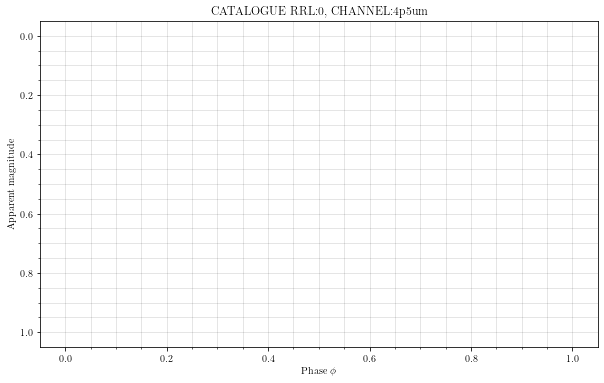

RRL Catalogue ID: 1

Gaia source_id = 2814893910504601600

     source_id              pf                pf_error       p1_o p1_o_error p2_o p2_o_error best_classification
                            d                    d            d       d       d       d                         
------------------- ------------------ --------------------- ---- ---------- ---- ---------- -------------------
2814893910504601600 0.5782076389734139 2.874269006799228e-06   --         --   --         --                RRab


RRL classification: RRab

Source ID: 1217

master_id         ra               dec        
--------- ----------------- ------------------
     1217 346.6853011617448 12.771080811648037




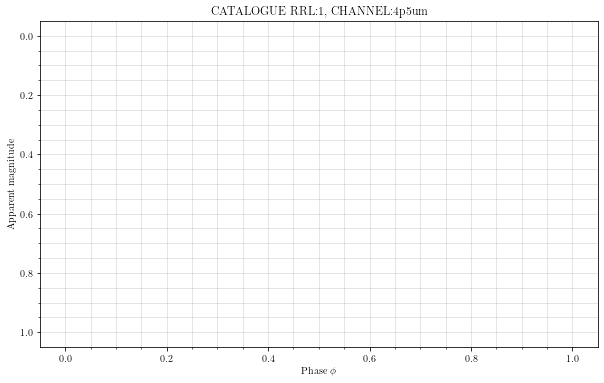

RRL Catalogue ID: 2

Gaia source_id = 2814893910504601600

     source_id              pf                pf_error       p1_o p1_o_error p2_o p2_o_error best_classification
                            d                    d            d       d       d       d                         
------------------- ------------------ --------------------- ---- ---------- ---- ---------- -------------------
2814893910504601600 0.5782076389734139 2.874269006799228e-06   --         --   --         --                RRab


RRL classification: RRab

Source ID: 1234

master_id         ra                dec       
--------- ------------------ -----------------
     1234 346.67973775312777 12.77988349328146




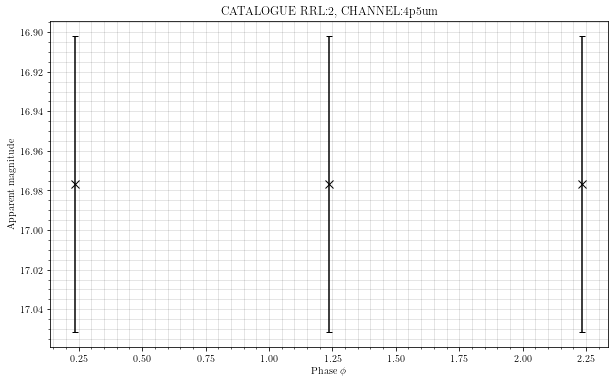

RRL Catalogue ID: 3

Gaia source_id = 2811888666052959232

     source_id              pf                pf_error       p1_o p1_o_error p2_o p2_o_error best_classification
                            d                    d            d       d       d       d                         
------------------- ------------------ --------------------- ---- ---------- ---- ---------- -------------------
2811888666052959232 0.5753486184073174 1.838950146836561e-06   --         --   --         --                RRab


RRL classification: RRab

Source ID: 449

master_id         ra                dec        
--------- ------------------ ------------------
      449 346.70348920350625 12.689711594227763




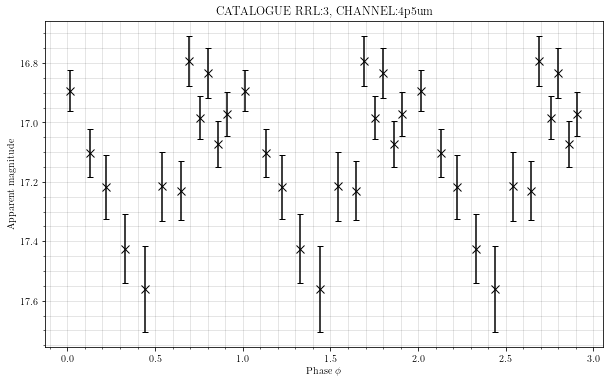

RRL Catalogue ID: 4

Source ID: 409

master_id         ra               dec        
--------- ----------------- ------------------
      409 346.6597847300598 12.823689330962845




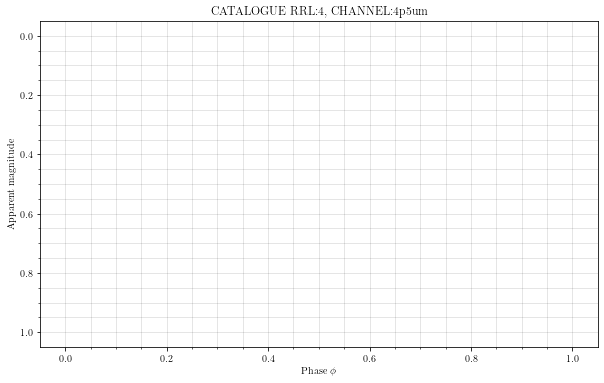

In [25]:
## LIGHT CURVE ANALYSIS ##

# OPTIONS
cluster       = cluster_input
channel       = '4p5um'
epoch_path    = epoch_path
main_file     = 'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/'+cluster+'_main_phot_'+channel+'.txt'
path1, path2  = epoch_path+cluster_input+'__e[0-9]_'+channel+'.fits', epoch_path+cluster+'__e[0-9][0-9]_'+channel+'.fits'

list_ch1 = []
list_ch2 = []

## READ IN MAIN TABLE AND GLOBULAR CLUSTER CATALOGUE ##

main_table = ascii.read(main_file, delimiter = ',', data_start = 1)

cat_file = 'CCVS_data/CCVS_'+cluster+'_RRLs_data.txt'
df_cat = ascii.read(cat_file, delimiter = ',', data_start = 1)

## CONVERT RA (UNITS: HMS) TO DEGREES AND DEC (UNITS: DMS) TO DEGREES ##

df_cat['ra_deg'] = str('null')
df_cat['dec_deg'] = str('null')
    
for col in df_cat.itercols():
    if col.dtype.kind in 'SU':
        df_cat.replace_column(col.name, col.astype('object'))
            
for i in range(len(df_cat)):
    ra_hms = Angle(df_cat['ra'][i], u.hour)
    df_cat['ra_deg'][i] = ra_hms.to_string(unit = u.deg, decimal = True)
for i in range(len(df_cat)):
    dec_hms = Angle(df_cat['dec'][i], u.degree)
    df_cat['dec_deg'][i] = dec_hms.to_string(unit = u.deg, decimal = True)

## WRITE TO NEW FILE : USE IN LIGHT CURVES ##

df_cat.write('CCVS_data/CCVS_{0}_RRLs_data_readin.txt'.format(cluster), format = 'csv', overwrite = True)

## READ IN GAIA DATA FOR STARS <10ARCMIN RADIUS OF PAL5 ##

vot_file = 'gaia_data/'+cluster+'_data/gaia_dr2_PAL13_read.vot'
votable = parse_single_table(vot_file).to_table()
gaia_data = votable
print('Gaia detected stars in {0}:\n'.format(cluster))
print(gaia_data['source_id', 'ra', 'dec']); print('\n')

## READ IN STAR CATALOGUE FROM CHRISTINE CLEMENT ##

rrl_cat = pd.read_csv('CCVS_data/CCVS_'+cluster+'_RRLs_data_readin.txt', sep = ',', header = 0)
print('RR Lyrae catalogue for {0}:\n'.format(cluster))
print(rrl_cat); print('\n')

## INITIALISE COORDINATE TRANSFORM/MATCHING ##

coord_rrl = SkyCoord(rrl_cat['ra_deg'], rrl_cat['dec_deg'], unit = u.degree)
coord_main = SkyCoord(main_table['ra'], main_table['dec'], unit = u.degree)
coord_gaia = SkyCoord(gaia_data['ra'], gaia_data['dec'], unit = u.degree)

## LOOP THROUGH ALL KNOWN RRLs AND PLOT LIGHT-CURVE ##
for i in range(len(rrl_cat)):
    target_rrl = i
    print('RRL Catalogue ID: {0}\n'.format(target_rrl))
    c = coord_rrl[target_rrl]
    
    source_id, d2d, d3d = c.match_to_catalog_sky(coord_gaia)
    rad = 1. * u.arcmin
    
    if (d2d < rad):
        
        gaia_source = gaia_data[source_id]['source_id']
        print('Gaia source_id = {0}\n'.format(gaia_source))
        
        ## READ IN ALL GAIA DR2 VARIABLE STARS [140784 stars] ##

        vot_file1 = 'gaia_data/'+cluster+'_data/gaia_dr2_rrls.vot'
        votable = parse_single_table(vot_file1).to_table()
        gaia_main = votable

        ## MATCH GAIA source_id TO STARS IDENTIFIED AROUND PAL5 ##

        for idx in range(len(gaia_main)):
            if gaia_main[idx]['source_id'] == gaia_source:
                main_id = idx
        print(gaia_main[main_id])
        print('\n')

        ## EXTRACT PERIODS FROM GAIA DATA ##
        ## IDENTIFY WHETHER FUNDAMENTAL OR FIRST OVERTONE ##

        if type(gaia_main[main_id]['pf']) == np.float64:
            rrl_class = 'RRab'
            P = gaia_main[main_id]['pf']
            P_err = gaia_main[main_id]['pf_error']
        elif type(gaia_main[main_id]['pf']) == np.ma.core.MaskedConstant:
            pass
        if type(gaia_main[main_id]['p1_o']) == np.float64:
            rrl_class = 'RRc'
            P = gaia_main[main_id]['p1_o']
            P_err = gaia_main[main_id]['p1_o_error']
        elif type(gaia_main[main_id]['p1_o']) == np.ma.core.MaskedConstant:
            pass
        print('RRL classification: {0}\n'.format(rrl_class))
        
        ## MATCH CATALOGUE TO MASTER SOURCE LIST ##

        main_id, d2d, d3d = c.match_to_catalog_sky(coord_main)
        if (d2d > 0.5 * u.arcmin):
            print('No match found to main photometry file. Select different channel.\n')
        else:
            print('Source ID: {0}\n'.format(main_id))
            print(main_table[main_id]['master_id', 'ra', 'dec'])
            print('\n')

            ## LIGHT CURVE TIME AND PHASE ##

            lctime = []

            for file in glob.glob(path1) + glob.glob(path2):
                with fits.open(file) as hdr_list:
                    e_hdr = hdr_list[0].header
                    lctime.append(Time(e_hdr['DATE_OBS'], format = 'isot', scale = 'utc').mjd)

            phase = []

            for i in lctime:
                func = i / P
                phase_val = func - np.floor(func)
                phase.append(phase_val)

            ## EXTRACTING MAGS AND UNCERTAINTIES FOR PLOT ##

            mag = []
            unc = []
            for i in range(1, 13):
                mag.append(main_table[main_id]['mag_e'+str(i)])
                unc.append(main_table[main_id]['unc_e'+str(i)])

            ## PLOT LIGHT CURVE ##

            lc_table = copy.copy(main_table.filled(-99))

            mag = np.ma.array(mag)
            mag = np.ma.masked_where(mag == -99, mag)
            unc = np.ma.array(unc)
            unc = np.ma.masked_where(unc == -99, unc)
            phase = np.ma.masked_array(phase, mag.mask)

            mag_long = np.concatenate((mag, mag, mag))
            unc_long = np.concatenate((unc, unc, unc))
            phase_long = np.concatenate((phase, phase + 1., phase + 2.))

            plt.errorbar(x = phase_long, y = mag_long, xerr = None, yerr = unc_long, fmt = 'kx', markersize = 8, capsize = 3)
            plt.xlabel(r'Phase $\phi$')
            plt.ylabel(r'Apparent magnitude')
            plt.title(r'CATALOGUE RRL:{0}, CHANNEL:{1}'.format(target_rrl, channel))
            plt.minorticks_on()
            plt.grid(b = True, which = 'major', lw = .5, alpha = .2, color = 'black')
            plt.grid(b = True, which = 'minor', lw = .5, alpha = .2, color = 'black')
            plt.gca().invert_yaxis()
            plt.gcf().set_size_inches(10, 6)
            plt.show()
            plt.close()

    else:
        P = rrl_cat['period'][target_rrl]
        
        ## MATCH CATALOGUE TO MASTER SOURCE LIST ##

        main_id, d2d, d3d = c.match_to_catalog_sky(coord_main)
        if (d2d > 0.5 * u.arcmin):
            print('No match found to main photometry file. Select different channel.\n')
        else:
            print('Source ID: {0}\n'.format(main_id))
            print(main_table[main_id]['master_id', 'ra', 'dec'])
            print('\n')

            ## LIGHT CURVE TIME AND PHASE ##

            lctime = []

            for file in glob.glob(path1) + glob.glob(path2):
                with fits.open(file) as hdr_list:
                    e_hdr = hdr_list[0].header
                    lctime.append(Time(e_hdr['DATE_OBS'], format = 'isot', scale = 'utc').mjd)

            phase = []

            for i in lctime:
                func = i / P
                phase_val = func - np.floor(func)
                phase.append(phase_val)

            ## EXTRACTING MAGS AND UNCERTAINTIES FOR PLOT ##

            mag = []
            unc = []
            for i in range(1, 13):
                mag.append(main_table[main_id]['mag_e'+str(i)])
                unc.append(main_table[main_id]['unc_e'+str(i)])

            ## PLOT LIGHT CURVE ##

            lc_table = copy.copy(main_table.filled(-99))

            mag = np.ma.array(mag)
            mag = np.ma.masked_where(mag == -99, mag)
            unc = np.ma.array(unc)
            unc = np.ma.masked_where(unc == -99, unc)
            phase = np.ma.masked_array(phase, mag.mask)

            mag_long = np.concatenate((mag, mag, mag))
            unc_long = np.concatenate((unc, unc, unc))
            phase_long = np.concatenate((phase, phase + 1., phase + 2.))

            plt.errorbar(x = phase_long, y = mag_long, xerr = None, yerr = unc_long, fmt = 'kx', markersize = 8, capsize = 3)
            plt.xlabel(r'Phase $\phi$')
            plt.ylabel(r'Apparent magnitude')
            plt.title(r'CATALOGUE RRL:{0}, CHANNEL:{1}'.format(target_rrl, channel))
            plt.minorticks_on()
            plt.grid(b = True, which = 'major', lw = .5, alpha = .2, color = 'black')
            plt.grid(b = True, which = 'minor', lw = .5, alpha = .2, color = 'black')
            plt.gca().invert_yaxis()
            plt.gcf().set_size_inches(10, 6)
            plt.show()
            plt.close()

##### Light curves: GLOESS (Gaussian locally estimated scatterplot smoothing)

In [16]:
## GLOESS LIGHT CURVES ##

# OPTIONS
cluster       = cluster_input
channel       = '4p5um'
epoch_path    = epoch_path
path1, path2  = epoch_path+cluster_input+'__e[0-9]_'+channel+'.fits', epoch_path+cluster+'__e[0-9][0-9]_'+channel+'.fits'

main_file_ch1 = 'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/'+cluster+'_main_phot_3p6um.txt'
main_file_ch2 = 'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/'+cluster+'_main_phot_4p5um.txt'

main_table1 = ascii.read(main_file_ch1, delimiter = ',', data_start = 1)
main_table2 = ascii.read(main_file_ch2, delimiter = ',', data_start = 1)

## REDO LIGHT CURVE X AXIS TO AVOID RUNNING ABOVE CODE ##
lctime = []

for file in glob.glob(path1) + glob.glob(path2):
    with fits.open(file) as hdr_list:
        e_hdr = hdr_list[0].header
        lctime.append(Time(e_hdr['DATE_OBS'], format = 'isot', scale = 'utc').mjd)

## READ IN GAIA DATA FOR STARS <10ARCMIN OF PAL5 ##

vot_file = 'gaia_data/'+cluster+'_data/gaia_dr2_PAL13_read.vot'
votable = parse_single_table(vot_file).to_table()
gaia_data = votable
print('Gaia - Variable stars around 10 arcmin of {0}:\n'.format(cluster))
print(gaia_data['source_id', 'ra', 'dec', 'parallax'])

## READ IN STAR CATALOGUE FROM CHRISTINE CLEMENT ##

rrl_cat = pd.read_csv('CCVS_data/CCVS_'+cluster+'_RRLs_data_readin.txt', sep = ',', header = 0)
print('RR Lyrae catalogue for {0}:\n'.format(cluster))
print(rrl_cat); print('\n')

## INITIALISE COORDINATE TRANSFORM/MATCHING ##

coord_rrl = SkyCoord(rrl_cat['ra_deg'], rrl_cat['dec_deg'], unit = u.degree)
coord_main1 = SkyCoord(main_table1['ra'], main_table1['dec'], unit = u.degree)
coord_main2 = SkyCoord(main_table2['ra'], main_table2['dec'], unit = u.degree)
coord_gaia = SkyCoord(gaia_data['ra'], gaia_data['dec'], unit = u.degree)

## LISTS FOR USE IN PL RELATIONS ##

av_mag1 = []
av_mag2 = []
av_unc1 = []
av_unc2 = []
av_std1 = []
av_std2 = []
period1 = []
period2 = []

## LOOP THROUGH ALL KNOWN RRLs AND PLOT LIGHT-CURVE ##
for i in range(len(rrl_cat)):
    target_rrl = i
    print('RRL Catalogue ID: {0}\n'.format(target_rrl))
    c = coord_rrl[target_rrl]
    
    source_id, d2d, d3d = c.match_to_catalog_sky(coord_gaia)
    rad = 0.25 * u.arcmin
    
    ## CHECK SIGNIFICANT MATCH TO GAIA DATA AROUND CLUSTER ##
    # THIS IS TO ENSURE WHETHER A GAIA PERIOD CAN BE USED OR A MANUAL
    # FIRST STATEMENT DEALS WITH SIGNIFICANT MATCHES
    # SECOND STATEMENT DEALS WITH USER INPUT PERIODS
    
    if (d2d < rad):
        
        gaia_source = gaia_data[source_id]['source_id']
        print('Gaia source_id = {0}\n'.format(gaia_source))
        
        ## READ IN ALL GAIA DR2 VARIABLE STARS [140784 stars] ##

        vot_file1 = 'gaia_data/'+cluster+'_data/gaia_dr2_rrls.vot'
        votable = parse_single_table(vot_file1).to_table()
        gaia_main = votable

        ## MATCH GAIA source_id TO STARS IDENTIFIED AROUND PAL5 ##

        for idx in range(len(gaia_main)):
            if gaia_main[idx]['source_id'] == gaia_source:
                main_id = idx
        if gaia_main[main_id]['source_id'] != gaia_source:
            print('No match in DR2 variable stars!\n')
            print(gaia_source)
            print(gaia_main[main_id]['source_id'])
            print('Manual period required.\n')

        ## EXTRACT PERIODS FROM GAIA DATA ##
        # IDENTIFY WHETHER FUNDAMENTAL OR FIRST OVERTONE OR BOTH
        # IF RRd TYPE THEN PLOTTING BOTH LIGHT CURVES REQUIRED
            # FIRST LEVEL EXTRACTS BOTH PERIODS, THEN CHECKS IF STAR PRESENT IN BOTH CHANNELS
                # PLOTS BOTH LIGHT CURVES AND ASKS USER INPUT AS TO WHICH LIGHT CURVE DATA TO ADD TO PL FIT LISTS
        # IF NOT RRd TYPE THEN JUST ONE LIGHT CURVE NEEDED
            # FIRST LEVEL EXTRACTS THE PERIOD, THEN CHECKS IF STAR PRESENT IN BOTH CHANNELS
            # ADDS DATA FOR EACH CHANNEL (WHERE POSSIBLE) TO PL FIT LISTS

        if gaia_main[main_id]['best_classification'] == b'RRd':
            if type(gaia_main[main_id]['pf']) == np.float64:
                P0 = gaia_main[main_id]['pf']
                P0_err = gaia_main[main_id]['pf_error']
            elif type(gaia_main[main_id]['pf']) == np.ma.core.MaskedConstant:
                pass
            if type(gaia_main[main_id]['p1_o']) == np.float64:
                P1 = gaia_main[main_id]['p1_o']
                P1_err = gaia_main[main_id]['p1_o_error']
            elif type(gaia_main[main_id]['p1_o']) == np.ma.core.MaskedConstant:
                pass
            print('RRL has two periods: P0 = {0:.8g} and P1 = {1:.8g}\n'.format(P0, P1))
            
            rrl_class = 'RRd'

            ## MATCH CATALOGUE TO MASTER SOURCE LIST ##
            
            main1_id, d2d, d3d = c.match_to_catalog_sky(coord_main1)
            main2_id, d2d2, d3d2 = c.match_to_catalog_sky(coord_main2)
            if (d2d > 0.5 * u.arcmin):
                multi = 0 # STAR NOT IN BOTH CHANNELS
                print('Channel 1: No match found to main photometry file. Select different channel.\n')
                print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))
            else:
                multi = 1 # STAR IS IN BOTH CHANNELS
                print('Channel 1 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main1_id, gaia_source))
                print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))
            
            ## FILL TABLE WITH 99 DUMMY INTS FOR GLOESS ##
            
            main_table1_m = copy.copy(main_table1.filled(99))
            main_table2_m = copy.copy(main_table2.filled(99))

            mag1 = []
            unc1 = []
            mag2 = []
            unc2 = []

            for i in range(1, 13):
                if multi == 1:
                    mag1.append(main_table1_m[main1_id]['mag_e'+str(i)])
                    unc1.append(main_table1_m[main1_id]['unc_e'+str(i)])
                if (multi == 0 or multi == 1):
                    mag2.append(main_table2_m[main2_id]['mag_e'+str(i)])
                    unc2.append(main_table2_m[main2_id]['unc_e'+str(i)])

            unc1 = np.array(unc1)
            unc2 = np.array(unc2)
            
            av_unc1_inter, av_unc2_inter = 0, 0
            
            if len(unc1) != 0:
                for i in range(len(unc1)):
                    av_unc1_inter += unc1[i]
                av_unc1_inter = av_unc1_inter / len(unc1)
            elif len(unc1) == 0:
                av_unc1_inter = float('NaN')
            
            for i in range(len(unc2)):
                av_unc2_inter += unc2[i]
                
            av_unc2_inter = av_unc2_inter / len(unc2)

            av_1a, am_1a, sd_1a, av_2a, am_2a, sd_2a = GLOESSpy(mag1, unc1, mag2, unc2, lctime, P0, 'RRL'+str(target_rrl), multi)
            
            print('GLOESSpy results for P0 = {0:.8g}:\n'.format(P0))
            print('mean_mag_ch1 = {0:.8g}\namplitude_ch1 = {1:.8g}\nsdev_ch1 = {2:.8g}\nmean_mag_ch2 = {3:.8g}\namplitude_ch2 = {4:.8g}\nsdev_ch2 = {5:.8g}\n'.format(av_1a, am_1a, sd_1a, av_2a, am_2a, sd_2a))
            print('mean_unc_ch1 = {0:.8g}\nmean_unc_ch2 = {1:.8g}'.format(av_unc1_inter, av_unc2_inter)); print('\n')
            
            av_1b, am_1b, sd_1b, av_2b, am_2b, sd_2b = GLOESSpy(mag1, unc1, mag2, unc2, lctime, P1, 'RRL'+str(target_rrl), multi)
            
            print('GLOESSpy results for P1 = {0:.8g}:\n'.format(P1))
            print('mean_mag_ch1 = {0:.8g}\namplitude_ch1 = {1:.8g}\nsdev_ch1 = {2:.8g}\nmean_mag_ch2 = {3:.8g}\namplitude_ch2 = {4:.8g}\nsdev_ch2 = {5:.8g}\n'.format(av_1b, am_1b, sd_1b, av_2b, am_2b, sd_2b))
            print('mean_unc_ch1 = {0:.8g}\nmean_unc_ch2 = {1:.8g}'.format(av_unc1_inter, av_unc2_inter)); print('\n')
            
            ## CHECK WHETHER PERIOD MUST BE FUNDAMENTALISED ##
            if rrl_class == 'RRd':
                P1 = np.log10(P1) + 0.127 + 0.3
            
            while True:
                print('Select which Period provides the most clarity: 1 or 2\n')
                sel = int(input())
                
                ## EXTRACTING THE VALUES FOR THE BEST LIGHT CURVE ##
                if sel == 1:
                    if np.isnan(av_1a) == True:
                        P_nan = float('nan')
                        av_mag1.append(av_1a)
                        av_unc1.append(av_unc1_inter)
                        av_std1.append(sd_1a)
                        period1.append(P_nan)
                    else:
                        av_mag1.append(av_1a)
                        av_unc1.append(av_unc1_inter)
                        av_std1.append(sd_1a)
                        period1.append(P1)
                        
                    av_mag2.append(av_2a)
                    av_unc2.append(av_unc2_inter)
                    av_std2.append(sd_2a)
                    period2.append(P1)
                elif sel == 2:
                    if np.isnan(av_1b) == True:
                        P_nan = float('nan')
                        av_mag1.append(av_1b)
                        av_unc1.append(av_unc1_inter)
                        av_std1.append(sd_1b)
                        period1.append(P_nan)
                    else:
                        av_mag1.append(av_1b)
                        av_unc1.append(av_unc1_inter)
                        av_std1.append(sd_1b)
                        period1.append(P1)
                        
                    av_mag2.append(av_2b)
                    av_unc2.append(av_unc2_inter)
                    av_std2.append(sd_2a)
                    period2.append(P1)
                break
            
        elif gaia_main[main_id]['best_classification'] != b'RRd':
            if type(gaia_main[main_id]['pf']) == np.float64:
                rrl_class = 'RRab'
                P = gaia_main[main_id]['pf']
                P_err = gaia_main[main_id]['pf_error']
            elif type(gaia_main[main_id]['pf']) == np.ma.core.MaskedConstant:
                pass
            if type(gaia_main[main_id]['p1_o']) == np.float64:
                rrl_class = 'RRc'
                P = gaia_main[main_id]['p1_o']
                P_err = gaia_main[main_id]['p1_o_error']
            elif type(gaia_main[main_id]['p1_o']) == np.ma.core.MaskedConstant:
                pass
            print('RRL classification: {0}\n'.format(rrl_class))

            ## USE PERIOD FROM CHRISTINE'S CATALOGUE IF STAR NOT FOUND IN GAIA OR INCORRECTLY MATCHED ##
            if gaia_main[main_id]['source_id'] != gaia_source:
                P = rrl_cat['period'][target_rrl]

            ## MATCH CATALOGUE TO MASTER SOURCE LIST ##

            main1_id, d2d, d3d = c.match_to_catalog_sky(coord_main1)
            main2_id, d2d2, d3d2 = c.match_to_catalog_sky(coord_main2)
            
            if (d2d > 0.5 * u.arcmin):
                multi = 0 # STAR NOT IN BOTH CHANNELS
                print('Channel 1: No match found to main photometry file. Select different channel.\n')
                print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))
            else:
                multi = 1 # STAR IS IN BOTH CHANNELS
                print('Channel 1 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main1_id, gaia_source))
                print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))
                
            ## FILL TABLE WITH 99 DUMMY INTS FOR GLOESS ##
            
            main_table1_m = copy.copy(main_table1.filled(99))
            main_table2_m = copy.copy(main_table2.filled(99))

            mag1 = []
            unc1 = []
            mag2 = []
            unc2 = []

            for i in range(1, 13):
                if multi == 1:
                    mag1.append(main_table1_m[main1_id]['mag_e'+str(i)])
                    unc1.append(main_table1_m[main1_id]['unc_e'+str(i)])
                if (multi == 0 or multi == 1):
                    mag2.append(main_table2_m[main2_id]['mag_e'+str(i)])
                    unc2.append(main_table2_m[main2_id]['unc_e'+str(i)])

            unc1 = np.ma.array(unc1)
            unc1 = np.ma.masked_where(unc1 == 99., unc1)
            unc2 = np.ma.array(unc2)
            unc2 = np.ma.masked_where(unc2 == 99., unc2)

            unc1_ma = []
            unc2_ma = []

            for i in range(len(unc1)):
                if type(unc1[i]) != np.ma.core.MaskedConstant:
                    unc1_ma.append(unc1[i])
            for i in range(len(unc2)):
                if type(unc2[i]) != np.ma.core.MaskedConstant:
                    unc2_ma.append(unc2[i])

            unc1_ma, unc2_ma = np.array(unc1_ma), np.array(unc2_ma)
            
            av_unc1_inter, av_unc2_inter = 0, 0
            
            if len(unc1_ma) != 0:
                for i in range(len(unc1_ma)):
                    av_unc1_inter += unc1_ma[i]
                av_unc1_inter = av_unc1_inter / len(unc1_ma)
            elif len(unc1_ma) == 0:
                av_unc1_inter = float('NaN')                    
          
            for i in range(len(unc2_ma)):
                av_unc2_inter += unc2_ma[i]
                
            av_unc2_inter = av_unc2_inter / len(unc2_ma)

            av_1, am_1, sd_1, av_2, am_2, sd_2 = GLOESSpy(mag1, unc1, mag2, unc2, lctime, P, 'RRL'+str(target_rrl), multi)
            
            print('GLOESSpy results for P = {0:.8g}:\n'.format(P))
            print('mean_mag_ch1 = {0:.8g}\namplitude_ch1 = {1:.8g}\nsdev_ch1 = {2:.8g}\nmean_mag_ch2 = {3:.8g}\namplitude_ch2 = {4:.8g}\nsdev_ch2 = {5:.8g}\n'.format(av_1, am_1, sd_1, av_2, am_2, sd_2))
            print('mean_unc_ch1 = {0:.8g}\nmean_unc_ch2 = {1:.8g}'.format(av_unc1_inter, av_unc2_inter)); print('\n')
            
            ## CHECK WHETHER PERIOD NEEDS TO BE FUNDAMENTALISED ##
            if rrl_class == 'RRab':
                P = np.log10(P) + 0.3
            elif rrl_class == 'RRc':
                P = np.log10(P) + 0.127 + 0.3
            
            ## EXTRACT THE VALUES AND APPEND TO LIGHT CURVE LISTS ##
            if np.isnan(av_1) == True:
                P1 = float('nan')
                av_mag1.append(av_1)
                av_unc1.append(av_unc1_inter)
                av_std1.append(sd_1)
                period1.append(P1)
            else:
                av_mag1.append(av_1)
                av_unc1.append(av_unc1_inter)
                av_std1.append(sd_1)
                period1.append(P)
                        
            av_mag2.append(av_2)
            av_unc2.append(av_unc2_inter)
            av_std2.append(sd_2)
            period2.append(P)
    else:
        print('Failed to find significant match to Gaia DR2 variable database: using catalogue stars.\n')
        P = rrl_cat['period'][target_rrl]
        
        ## MATCH CATALOGUE TO MASTER SOURCE LIST ##

        main1_id, d2d, d3d = c.match_to_catalog_sky(coord_main1)
        main2_id, d2d2, d3d2 = c.match_to_catalog_sky(coord_main2)
            
        if (d2d > 0.5 * u.arcmin):
            multi = 0 # STAR NOT IN BOTH CHANNELS
            print('Channel 1: No match found to main photometry file. Select different channel.\n')
            print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))
        else:
            multi = 1 # STAR IS IN BOTH CHANNELS
            print('Channel 1 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main1_id, gaia_source))
            print('Channel 2 MAIN_ID: {0}\nGAIA ID: {1}\n'.format(main2_id, gaia_source))
                
        ## FILL TABLE WITH 99 DUMMY INTS FOR GLOESS ##
            
        main_table1_m = copy.copy(main_table1.filled(99))
        main_table2_m = copy.copy(main_table2.filled(99))

        mag1 = []
        unc1 = []
        mag2 = []
        unc2 = []

        for i in range(1, 13):
            if multi == 1:
                mag1.append(main_table1_m[main1_id]['mag_e'+str(i)])
                unc1.append(main_table1_m[main1_id]['unc_e'+str(i)])
            if (multi == 0 or multi == 1):
                mag2.append(main_table2_m[main2_id]['mag_e'+str(i)])
                unc2.append(main_table2_m[main2_id]['unc_e'+str(i)])
        
        unc1 = np.ma.array(unc1)
        unc1 = np.ma.masked_where(unc1 == 99., unc1)
        unc2 = np.ma.array(unc2)
        unc2 = np.ma.masked_where(unc2 == 99., unc2)

        unc1_ma = []
        unc2_ma = []

        for i in range(len(unc1)):
            if type(unc1[i]) != np.ma.core.MaskedConstant:
                unc1_ma.append(unc1[i])
        for i in range(len(unc2)):
            if type(unc2[i]) != np.ma.core.MaskedConstant:
                unc2_ma.append(unc2[i])

        unc1_ma, unc2_ma = np.array(unc1_ma), np.array(unc2_ma)
            
        av_unc1_inter, av_unc2_inter = 0, 0
            
        if len(unc1_ma) != 0:
            for i in range(len(unc1_ma)):
                av_unc1_inter += unc1_ma[i]
            av_unc1_inter = av_unc1_inter / len(unc1_ma)
        elif len(unc1_ma) == 0:
            av_unc1_inter = float('NaN')
            
        for i in range(len(unc2_ma)):
            av_unc2_inter += unc2_ma[i]
                
        av_unc2_inter = av_unc2_inter / len(unc2_ma)

        av_1, am_1, sd_1, av_2, am_2, sd_2 = GLOESSpy(mag1, unc1, mag2, unc2, lctime, P, 'RRL'+str(target_rrl), multi)
            
        print('GLOESSpy results for P = {0:.8g}:\n'.format(P))
        print('mean_mag_ch1 = {0:.8g}\namplitude_ch1 = {1:.8g}\nsdev_ch1 = {2:.8g}\nmean_mag_ch2 = {3:.8g}\namplitude_ch2 = {4:.8g}\nsdev_ch2 = {5:.8g}\n'.format(av_1, am_1, sd_1, av_2, am_2, sd_2))
        print('mean_unc_ch1 = {0:.8g}\nmean_unc_ch2 = {1:.8g}'.format(av_unc1_inter, av_unc2_inter)); print('\n')
            
        ## CHECK WHETHER PERIOD MUST BE FUNDAMENTALISED ##
        if rrl_cat['type'][target_rrl] == 'RR0':
            P = np.log10(P) + 0.3
        elif rrl_cat['type'][target_rrl] == 'RR1':
            P = np.log10(P) + 0.127 + 0.3
        
        ## EXTRACT THE VALUES AND APPEND TO LIGHT CURVE LISTS ##

        if np.isnan(av_1) == True:
            P1 = float('nan')
            av_mag1.append(av_1)
            av_unc1.append(av_unc1_inter)
            av_std1.append(sd_1)
            period1.append(P1)
        else:
            P1 = P
            av_mag1.append(av_1)
            av_unc1.append(av_unc1_inter)
            av_std1.append(sd_1)
            period1.append(P1)
                        
        av_mag2.append(av_2)
        av_unc2.append(av_unc2_inter)
        av_std2.append(sd_2)
        period2.append(P)
        
## REMOVING NANS FROM RESULTS ##

av_mag1, av_unc1, av_std1, period1 = np.array(av_mag1), np.array(av_unc1), np.array(av_std1), np.array(period1)
av_mag2, av_unc2, av_std2, period2 = np.array(av_mag2), np.array(av_unc2), np.array(av_std2), np.array(period2)

def NaNmask(data):
    mask = ~np.isnan(data)
    result = data[mask]
    return result

av_mag1 = NaNmask(av_mag1)
av_unc1 = NaNmask(av_unc1)
av_mag2 = NaNmask(av_mag2)
av_unc2 = NaNmask(av_unc2)
av_std1 = NaNmask(av_std1)
av_std2 = NaNmask(av_std2)
period1 = NaNmask(period1)
period2 = NaNmask(period2)

## EXTINCTION CORRECTION ##
# NOTE: AS STARS OCCUPY AREA OF LOWER RESOLUTION THAN DUST MAP (CHECKED), FUNCTION WILL AUTO SUBTRACT THE FINAL EXT. VALUE
def extinction_corr(star_table, data1, data2):
    stars = star_table
    for i in range(len(stars)):
        ra = stars['ra_deg'][i]
        dec = stars['dec_deg'][i]
        #print('Coords: ra = {0} d, dec = {1} d\n'.format(ra, dec))
        c = SkyCoord(ra, dec, unit = u.degree, frame = 'icrs')
        table = IrsaDust.get_extinction_table(c)
        irac1_ext = table[19][3]
        irac2_ext = table[20][3]

    data_in1 = data1
    data_in2 = data2
    data_out1 = data_in1 - irac1_ext
    data_out2 = data_in2 - irac2_ext
    return data_out1, data_out2

av_mag1, av_mag2 = extinction_corr(rrl_cat, av_mag1, av_mag2)

print('Channel 1 results:\nAverage Mags:\n{0}\nAverage Uncertainty (Mag):\n{1}\nPeriod:\n{2}\n'
      .format(av_mag1,av_unc1,period1))
print('Channel 2 results:\nAverage Mags:\n{0}\nAverage Uncertainty (Mag):\n{1}\nPeriod:\n{2}\n'
      .format(av_mag2,av_unc2,period2))

Gaia - Variable stars around 10 arcmin of PAL13:

     source_id              ra                dec               parallax      
                           deg                deg                 mas         
------------------- ------------------ ------------------ --------------------
2814801066196201088  346.5418535077791 12.718023277588058  0.47948760673004365
2814797840676269952  346.5816049815254 12.686111053800442    2.467842823825295
2814797630222339200 346.56800510181444 12.660132394892765  -0.2321122692375306
2814797733301554816  346.5718818929496 12.661265378980879  0.30184817310033646
2814798008179470336 346.55923211090686 12.683874875935748   1.3348324748406935
2814797767661454976   346.590647569446 12.669762114768377   0.8482710467134614
2814796977387471872 346.58268436534274 12.651019281900265  -1.4337871763669865
2814797011747210624 346.59744904308485 12.666028215890329   1.8831764079145912
2814796874308087936  346.5791477814666  12.64546127783454   0.1928502038635437
28

ZeroDivisionError: division by zero

##### Fit PL relations

In [ ]:
## FIT PARAMETERS ##

if (channel == 1) or (channel == '3p6um'):
    a1     = -0.40    ## VALUES FROM: NEELEY ET AL. 2019
    a1_unc = 0.03
    b      = -2.78
    b_unc  = 0.38
if (channel == 2) or (channel == '4p5um'):
    a1     = -0.41    ## VALUES FROM: NEELEY ET AL. 2019
    a1_unc = 0.03
    b      = -2.83
    b_unc  = 0.39

## FUNCTIONS FOR FIT AND DISTANCE ##

def func(P, intercept):
    return intercept + b * P

def distance(a1, a2):
    a1 = a1
    a2 = a2
    d = 10 ** (1 + (a2 - a1) / 5)
    return d

##_________________##
## FIT : CHANNEL 1 ##

channel = '3p6um'

## FIT PL RELATION ##

popt, pcov = curve_fit(func, period1, av_mag1)

a2 = popt[0]
a2_unc = np.sqrt(float(pcov[0][0]))

## STANDARD DEVIATION OF POINTS ABOUT THE PL FIT ##
std_dev1 = 0
for i in range(len(av_mag1)):
    std_dev1 += (av_mag1[i] - (a2 + b * period1[i]))**2
std_dev1 = np.sqrt(std_dev1 / len(av_mag1))

fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(period1, av_mag1, xerr = None, yerr = av_unc1, marker = 'x', color = 'blue', markersize = 10, capsize = 3, linestyle = 'None')
ax.set_xlabel(r'${log(P) + 0.3}$')
ax.set_ylabel('Mean apparent magnitude')
x = np.linspace(min(period1), max(period1), 100)
y = np.linspace(min(period1), max(period1), 100)
ax.plot(y, y * b + (a2 + std_dev1), linestyle = '--', color = 'maroon')
ax.plot(y, y * b + (a2 - std_dev1), linestyle = '--', color = 'maroon')
ax.plot(x, x * b + a2, linestyle = '-', color = 'red')
plt.title('{0} PL relation: channel {1}'.format(cluster, channel))
plt.minorticks_on()
plt.grid(b = True, which = 'major', lw = .5, alpha = .2, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, alpha = .2, color = 'black')
plt.gca().invert_yaxis()
savename = 'pl_relations/pl_relation_'+str(cluster)+'_'+str(channel)
plt.savefig(savename)
plt.show()
plt.close()

modulus = a2 - a1

d = distance(a1, a2) / 1000

## UNCERTAINTY CALCULATIONS ##

## RANDOM UNCERTAINTY IN DISTANCE MODULUS: u ##

sigma_u = np.sqrt(a1_unc**2 + a2_unc**2)
# PROPAGATE THROUGH TO DISTANCE: d
sigma_d = d * (np.log(10) * sigma_u / 5)

## SYSTEMATIC UNCERTAINTY IN DISTANCE MODULUS (FROM PL FIT): u ##

sigma_u_sys = np.sqrt(a1_unc**2 + (0.3 * b_unc)**2)
# PROPAGATE THROUGH TO DISTANCE: d
sigma_d_sys = d * (np.log(10) * sigma_u_sys / 5)

print('Intercept a\N{SUBSCRIPT TWO}             = {0:.2f} ± {1:.2f}'.format(intercept, intercept_unc))
print('Distance modulus a\N{SUBSCRIPT TWO} - a\N{SUBSCRIPT ONE} = {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(modulus, sigma_u, sigma_u_sys))
print('Distance to {0}         = {1:.4g} ± {2:.2f} (random) ± {3:.2f} (systematic) kpc'.format(cluster, d, sigma_d, sigma_d_sys))

##_________________##
## FIT : CHANNEL 2 ##

channel = '4p5um'

## FIT PL RELATION ##

popt, pcov = curve_fit(func, period2, av_mag2)

a2 = popt[0]
a2_unc = np.sqrt(float(pcov[0][0]))

## STANDARD DEVIATION OF POINTS ABOUT THE PL FIT ##
std_dev2 = 0
for i in range(len(av_mag2)):
    std_dev2 += (av_mag2[i] - (a2 + b * period2[i]))**2
std_dev2 = np.sqrt(std_dev2 / len(av_mag2))

fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(period2, av_mag2, xerr = None, yerr = av_unc2, marker = 'x', color = 'blue', markersize = 10, capsize = 3, linestyle = 'None')
ax.set_xlabel(r'${log(P) + 0.3}$')
ax.set_ylabel('Mean apparent magnitude')
x = np.linspace(min(period2), max(period2), 100)
y = np.linspace(min(period2), max(period2), 100)
ax.plot(y, y * b + (a2 + std_dev2), linestyle = '--', color = 'maroon')
ax.plot(y, y * b + (a2 - std_dev2), linestyle = '--', color = 'maroon')
ax.plot(x, x * b + a2, linestyle = '-', color = 'red')
plt.title('{0} PL relation: channel {1}'.format(cluster, channel))
plt.minorticks_on()
plt.grid(b = True, which = 'major', lw = .5, alpha = .2, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, alpha = .2, color = 'black')
plt.gca().invert_yaxis()
savename = 'pl_relations/pl_relation_'+str(cluster)+'_'+str(channel)
plt.savefig(savename)
plt.show()
plt.close()

modulus = a2 - a1

d = distance(a1, a2) / 1000

## UNCERTAINTY CALCULATIONS ##

## RANDOM UNCERTAINTY IN DISTANCE MODULUS: u ##

sigma_u = np.sqrt(a1_unc**2 + a2_unc**2)
# PROPAGATE THROUGH TO DISTANCE: d
sigma_d = d * (np.log(10) * sigma_u / 5)

## SYSTEMATIC UNCERTAINTY IN DISTANCE MODULUS (FROM PL FIT): u ##

sigma_u_sys = np.sqrt(a1_unc**2 + (0.3 * b_unc)**2)
# PROPAGATE THROUGH TO DISTANCE: d
sigma_d_sys = d * (np.log(10) * sigma_u_sys / 5)

print('Intercept a\N{SUBSCRIPT TWO}             = {0:.2f} ± {1:.2f}'.format(intercept, intercept_unc))
print('Distance modulus a\N{SUBSCRIPT TWO} - a\N{SUBSCRIPT ONE} = {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(modulus, sigma_u, sigma_u_sys))
print('Distance to {0}         = {1:.4g} ± {2:.2f} (random) ± {3:.2f} (systematic) kpc'.format(cluster, d, sigma_d, sigma_d_sys))

##__________________##
## FIT : CHANNEL 2a ##

channel = '4p5um'

## OBTAIN STARS COMMON TO BOTH CHANNELS ##

period3 = []
av_mag3 = []
av_unc3 = []

for i in range(len(period2)):
    for j in range(len(period1)):
        if period1[[j]] == period2[[i]]:
            period3.append(period1[j])
            av_mag3.append(av_mag2[i])
            av_unc3.append(av_unc2[i])

av_mag3, av_unc3, period3 = np.array(av_mag3), np.array(av_unc3), np.array(period3)

## FIT PL RELATION ##

popt, pcov = curve_fit(func, period3, av_mag3)

a2 = popt[0]
a2_unc = np.sqrt(float(pcov[0][0]))

## STANDARD DEVIATION OF POINTS ABOUT THE PL FIT ##
std_dev3 = 0
for i in range(len(av_mag3)):
    std_dev3 += (av_mag3[i] - (a2 + b * period3[i]))**2
std_dev3 = np.sqrt(std_dev3 / len(av_mag3))

fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(period3, av_mag3, xerr = None, yerr = av_unc3, marker = 'x', color = 'blue', markersize = 10, capsize = 3, linestyle = 'None')
ax.set_xlabel(r'${log(P) + 0.3}$')
ax.set_ylabel('Mean apparent magnitude')
x = np.linspace(min(period3), max(period3), 100)
y = np.linspace(min(period3), max(period3), 100)
ax.plot(y, y * b + (a2 + std_dev3), linestyle = '--', color = 'maroon')
ax.plot(y, y * b + (a2 - std_dev3), linestyle = '--', color = 'maroon')
ax.plot(x, x * b + a2, linestyle = '-', color = 'red')
plt.title('{0} PL relation: channel {1} (channel 1 stars)'.format(cluster, channel))
plt.minorticks_on()
plt.grid(b = True, which = 'major', lw = .5, alpha = .2, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, alpha = .2, color = 'black')
plt.gca().invert_yaxis()
savename = 'pl_relations/pl_relation_'+str(cluster)+'_'+str(channel)+'ch1_combined_ch2'
plt.savefig(savename)
plt.show()
plt.close()

modulus = a2 - a1

d = distance(a1, a2) / 1000

## UNCERTAINTY CALCULATIONS ##

## RANDOM UNCERTAINTY IN DISTANCE MODULUS: u ##

sigma_u = np.sqrt(a1_unc**2 + a2_unc**2)
# PROPAGATE THROUGH TO DISTANCE: d
sigma_d = d * (np.log(10) * sigma_u / 5)

## SYSTEMATIC UNCERTAINTY IN DISTANCE MODULUS (FROM PL FIT): u ##

sigma_u_sys = np.sqrt(a1_unc**2 + (0.3 * b_unc)**2)
# PROPAGATE THROUGH TO DISTANCE: d
sigma_d_sys = d * (np.log(10) * sigma_u_sys / 5)

print('Intercept a\N{SUBSCRIPT TWO}             = {0:.2f} ± {1:.2f}'.format(intercept, intercept_unc))
print('Distance modulus a\N{SUBSCRIPT TWO} - a\N{SUBSCRIPT ONE} = {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(modulus, sigma_u, sigma_u_sys))
print('Distance to {0}         = {1:.4g} ± {2:.2f} (random) ± {3:.2f} (systematic) kpc'.format(cluster, d, sigma_d, sigma_d_sys))